In [1]:
from torchsummary import summary 

/home/kjs2109/.conda/envs/deepai-kjs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.unet import EfficientUNet 

In [3]:
model = EfficientUNet(classes=['pneumothorax'])
summary(model, input_size=(3, 512, 512), batch_size=1, device='cpu') 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1, 136, 256, 256]           3,672
          Identity-2         [1, 136, 256, 256]               0
             Swish-3         [1, 136, 256, 256]               0
    BatchNormAct2d-4         [1, 136, 256, 256]             272
            Conv2d-5         [1, 136, 256, 256]           1,224
          Identity-6         [1, 136, 256, 256]               0
             Swish-7         [1, 136, 256, 256]               0
    BatchNormAct2d-8         [1, 136, 256, 256]             272
            Conv2d-9              [1, 34, 1, 1]           4,658
            Swish-10              [1, 34, 1, 1]               0
           Conv2d-11             [1, 136, 1, 1]           4,760
          Sigmoid-12             [1, 136, 1, 1]               0
    SqueezeExcite-13         [1, 136, 256, 256]               0
           Conv2d-14          [1, 72, 2

In [4]:
import torch 
dumy_input = torch.randn(4, 3, 512, 512) 

model1 = EfficientUNet(classes=['pneumothorax', 'consolidation'], use_aux=True) 
output = model1(dumy_input) 
# summary(model1, input_size=(3, 512, 512), batch_size=1, device='cpu') 

In [5]:
output.keys() 

dict_keys(['mask_output', 'cls_output'])

In [6]:
output['mask_output'].shape, output['cls_output'].shape 

(torch.Size([4, 2, 512, 512]), torch.Size([4, 2]))

In [18]:
output['classifications'].dtype

torch.float32

In [4]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path = '/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/exp2_scheduler/dice-7960-9999.pth'

model1 = EfficientUNet(classes=['pneumothorax']) 
model1.load_state_dict(torch.load(weight_path)) 
model1.to(device) 

EfficientUNet(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            64, 16, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            16, 64, kernel_size=(1, 1), stride=

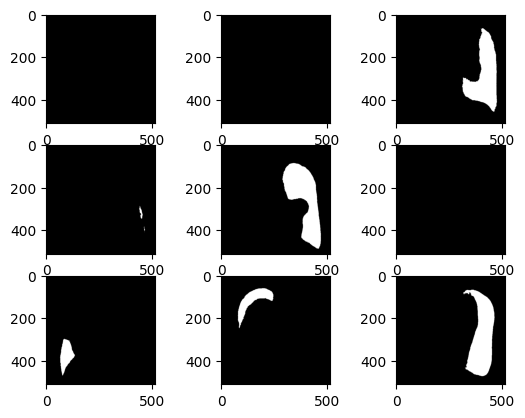

In [10]:
import cv2 
import albumentations as A
import matplotlib.pyplot as plt 

image_paths = [
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_006615.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_007688.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010424.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010492.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010481.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_002481.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010456.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010594.jpg', 
    '/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010714.jpg'
]


transform = A.Resize(512, 512)

fig, axes = plt.subplots(3, 3) 

for i, img_path in enumerate(image_paths): 
    img = image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = transform(image=img)['image'] 
    img = torch.from_numpy(img).type(torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
    img = img / 255.0 

    model1.eval() 
    with torch.no_grad(): 
        logit = model1(img)

    pred = torch.sigmoid(logit).cpu().numpy() 
    mask = (pred > 0.5) 

    axes[i//3][i%3].imshow(mask[0][0], cmap='gray') 
plt.show() 

In [12]:
pred.min(), pred.max() 

(3.815576e-05, 0.9975514)

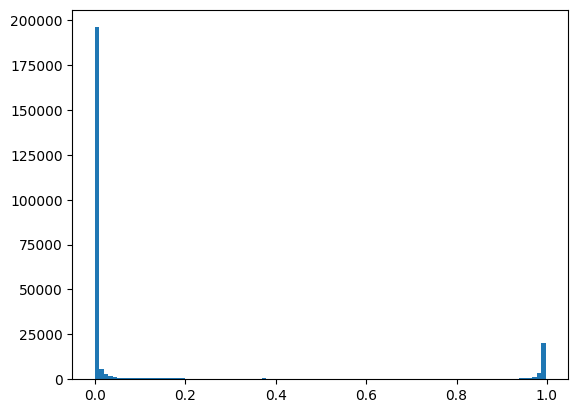

In [14]:
probs = pred[0][0].reshape(-1) 

plt.hist(probs, bins=100) 
plt.show() 

In [18]:
import numpy as np 

contours, h = cv2.findContours(mask[0][0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

In [20]:
polygons = [] 

for contour in contours: 
    if len(contour) <= 4: 
        continue
    polygons.append(contour.squeeze())  

polygons 

[array([[354,  69],
        [353,  70],
        [352,  70],
        [351,  71],
        [340,  71],
        [339,  70],
        [332,  70],
        [330,  72],
        [328,  72],
        [326,  74],
        [325,  74],
        [325,  75],
        [324,  76],
        [323,  76],
        [324,  77],
        [323,  78],
        [323,  79],
        [322,  80],
        [319,  80],
        [318,  81],
        [317,  81],
        [317,  82],
        [316,  83],
        [316,  84],
        [317,  85],
        [316,  86],
        [317,  87],
        [323,  87],
        [322,  86],
        [323,  85],
        [324,  85],
        [325,  86],
        [325,  85],
        [326,  84],
        [327,  84],
        [328,  85],
        [328,  87],
        [329,  87],
        [328,  86],
        [330,  84],
        [331,  84],
        [332,  83],
        [333,  83],
        [335,  85],
        [338,  85],
        [339,  86],
        [338,  87],
        [338,  88],
        [339,  89],
        [343,  89],


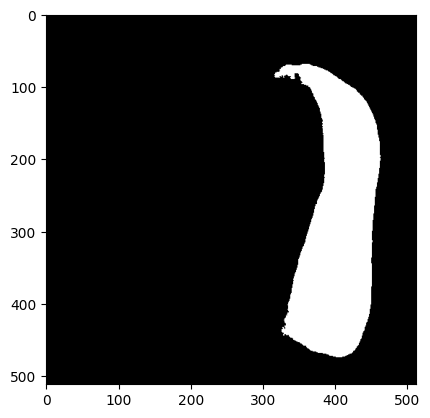

: 

In [21]:
draw_mask = np.zeros((512, 512), dtype=np.uint8) 
draw_mask = cv2.fillPoly(draw_mask, polygons, 1) 

plt.imshow(draw_mask, cmap='gray') 

In [9]:
import numpy as np 

classes = ['a', 'b', 'c']
cls_label = np.zeros((1, len(classes)), dtype=np.uint8) 
print(cls_label.shape) 
print(cls_label) 

(1, 3)
[[0 0 0]]


In [13]:
cat_id = 1
cls_label[0][cat_id] = 1 

cat_id = 1 
cls_label[0][cat_id] = 1 

cls_label 

array([[0., 1., 0.]])

In [14]:
cls_label[0][cat_id].dtype 

dtype('float64')

In [10]:
np.zeros(3)

array([0., 0., 0.])

In [2]:
import torch 

logits = torch.tensor([[-0.4279, -0.4279], [-0.3417, -0.3417], [-0.5975, -0.5975], [-0.3801, -0.3801], [-0.5078, -0.5078]])  # NC 

torch.sigmoid(logits)

tensor([[0.3946, 0.3946],
        [0.4154, 0.4154],
        [0.3549, 0.3549],
        [0.4061, 0.4061],
        [0.3757, 0.3757]])

In [4]:
pred = torch.tensor([[0, 0, 0], 
                     [1, 0, 1]])  # NC  
gt = torch.tensor([[0, 0, 0], 
                   [1, 1, 1]]) 

torch.eq(pred, gt).sum(dim=0) 

tensor([2, 1, 2])

In [5]:
torch.eq(pred, gt).sum(dim=0) / len(pred) 

tensor([1.0000, 0.5000, 1.0000])

In [6]:
d_dict = {'a': 1, 'b': 2, 'c': 3} 
a_dict = {'d': 1, 'e': 2, 'f': 3} 

d_dict.update(a_dict) 

In [7]:
d_dict 

{'a': 1, 'b': 2, 'c': 3, 'd': 1, 'e': 2, 'f': 3}

In [11]:
import torch 
output = torch.randint(0, 10, (4, 5, 3, 3)) 
output.shape

torch.Size([4, 5, 3, 3])

In [12]:
values, indices = output.view(4, -1, 3*3).max(dim=-1)  

In [14]:
values_ = values / 10 # NC 
values_[0][0] = 0.1 
values_ 

tensor([[0.1000, 0.9000, 0.6000, 0.9000, 0.9000],
        [0.9000, 0.7000, 0.7000, 0.7000, 0.9000],
        [0.5000, 0.8000, 0.9000, 0.9000, 0.9000],
        [0.9000, 0.4000, 0.7000, 0.7000, 0.8000]])

In [15]:
torch.round(values_)

tensor([[0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.]])

In [17]:
acc = torch.round(values_) 
torch.mean(acc).item()  

0.8500000238418579

In [24]:
torch.mean(acc, dim=0)

tensor([0.5000, 0.7500, 1.0000, 1.0000, 1.0000])

In [20]:
acc.unsqueeze(1).shape 

torch.Size([4, 1, 5])

In [22]:
torch.stack(acc.shape , 0)

TypeError: expected Tensor as element 0 in argument 0, but got int

In [29]:
a = torch.ones(4, 5)
a

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [27]:
acc 

tensor([[0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.]])

In [34]:
correct = torch.eq(acc, a) 
correct

tensor([[False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [ True, False,  True,  True,  True]])

In [35]:
correct.sum(dim=0) 

tensor([2, 3, 4, 4, 4])

In [59]:
a = torch.tensor([[1, 1], [1, 2], [0, 3], [0, 4]])  # NC 
print(a.sum(dim=0).shape) 
a.sum(dim=0).numpy()  

torch.Size([2])


array([ 2, 10])

In [60]:
accuracy_list = [] 
for i in range(10):
    b = a.sum(dim=0).numpy() 
    accuracy_list.append(b)

# torch.tensor(accuracy_list).shape 

In [64]:
import numpy as np 
np.array(accuracy_list).shape

(10, 2)

In [65]:
accuracy_list

[array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10]),
 array([ 2, 10])]

In [71]:
[a.item() for a in np.mean(accuracy_list, 0)]  

[2.0, 10.0]

In [69]:
np.mean(accuracy_list, axis=0)

array([ 2., 10.])